# Peer-graded Assignment: Эксперименты с моделью

На прошлой неделе вы поучаствовали в соревновании на kaggle и, наверняка, большинство успешно справилось с прохождением baseline, а значит пора двигаться дальше - заняться оптимизацией модели, провести серию экспериментов и построить сильное финальное решения.

В этом задании вам нужно провести ряд эскпериментов, оценить качество полученных в процессе экспериментирования моделей и выбрать лучшее решение. 

Задание будет оцениваться на основании загруженного jupyther notebook и развернутых ответов на поставленные вопросы.

In [4]:
import pandas as pd
import numpy as np
from collections import OrderedDict

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold

from sklearn.metrics import roc_auc_score

from xgboost import XGBClassifier

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import Imputer

from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction import FeatureHasher

from sklearn.model_selection import learning_curve

from imblearn.under_sampling import TomekLinks
from imblearn.under_sampling import ClusterCentroids
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek

from sklearn.feature_selection import SelectFromModel

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [5]:
# загрузка данных 

def read_df_from_csv():
    '''читаем данные из CSV файла'''
    
    churn_data_df = pd.read_csv('orange_small_churn_data.txt', sep=',')
    labels_df = pd.read_csv('orange_small_churn_labels.txt', sep=',', names=['label'])
    labels_df['target'] = labels_df.label == 1
    labels_df = labels_df.drop(['label'], axis=1)
    full_df = pd.concat([churn_data_df, labels_df], axis=1, sort=False)
    return full_df

def sample_prepare(data_df, unimportant_features = []):
    '''готовим выборку'''
    
    labels_df = data_df[['target']]
    data_df = data_df.drop(['target'], axis=1)
    
    columns = data_df.columns
    columns_numbers = data_df.columns[:190]
    columns_cat = data_df.columns[-40:]

    # удаляем признаки не содержащине данных 
    empty_columns = []

    for col_name in columns:
        # проверям, что вообще нет данных 
        if len(data_df[col_name].value_counts()) == 0: 
           empty_columns.append(col_name) 
        
    empty_columns += unimportant_features

    columns_numbers = [x for x in columns_numbers if x not in empty_columns]
    columns_cat = [x for x in columns_cat if x not in empty_columns]

    data_without_nulls = data_df[[x for x in columns if x not in empty_columns]]

    # разные выборки для обучения и валидации
    X, X_hold_out, y, y_hold_out = train_test_split(data_without_nulls, labels_df.target, test_size=0.1, random_state=42)
    _, X_small, _, y_small = train_test_split(X, y, test_size=0.4, random_state=42)  # сокращенная выборка для быстрой проверки
    
    Xy = pd.concat([X, pd.DataFrame(y)], axis=1, sort=False)  # выборка с признаками и целевой переменной
    Xy_calss0 = Xy[Xy.target == 0]
    Xy_calss1 = Xy[Xy.target == 1]

    
    return (X, y, X_small, y_small, X_hold_out, y_hold_out, 
            columns, columns_numbers, columns_cat,
            Xy, Xy_calss0, Xy_calss1)

In [86]:
full_df = read_df_from_csv()

(X, y, X_small, y_small, X_hold_out, y_hold_out, 
    columns, columns_numbers, columns_cat,
    Xy, Xy_calss0, Xy_calss1) = sample_prepare(full_df)

print "Размер hold out выборки: {}".format(X_hold_out.shape)
print "Размер основной выборки: {}".format(X.shape)
print "Размер сокращенной выборки: {}".format(X_small.shape)

Размер hold out выборки: (4000, 212)
Размер основной выборки: (36000, 212)
Размер сокращенной выборки: (14400, 212)


In [84]:
# Pipeline

def set_cat_features_lists(threshold):
    '''разбивает категориальные признаки на группы'''
    
    columns_with_uniq_values = {}
    for col_name in columns_cat:
        columns_with_uniq_values[col_name] = (
            len(full_df[col_name].value_counts()), 
            (full_df[col_name].notnull()).sum()
        )

    ordered = OrderedDict(sorted(columns_with_uniq_values.items(), key=lambda t: t[1][0]))

    global columns_cat_for_one_hot_encoding
    global columns_cat_for_trick

    columns_cat_for_one_hot_encoding = [k for k, v in columns_with_uniq_values.iteritems() if v[0] <= threshold] 
    columns_cat_for_trick = [k for k, v in columns_with_uniq_values.iteritems() if v[0] > threshold]
    
def fit_vectorizers(X):
    '''обучает векторайзеры'''
    
    vectorizer_ohe = DictVectorizer(sparse=False)
    vectorizer_trick = DictVectorizer(sparse=False)
    
    vectorizer_ohe.fit(X[columns_cat_for_one_hot_encoding].fillna('no_data').to_dict('records'))

    data_cat_for_trick = X[columns_cat_for_trick].fillna('no_data').copy()
    for col_name in columns_cat_for_trick:
        top_values = list(data_cat_for_trick[col_name].value_counts()[:25].index)
        data_cat_for_trick[col_name] = data_cat_for_trick[col_name].apply(lambda x: x if x in top_values else 'rare')

    vectorizer_trick.fit(data_cat_for_trick.to_dict('records'))

    return vectorizer_ohe, vectorizer_trick

def fit_positive_probability_for_cat_values(X, y):
    '''веротяность появления значения признака'''
    
    X_without_nulls = X[columns_cat_for_trick].fillna('no_data')
    results = {}
    
    for col_name in columns_cat_for_trick:
        all_values = X_without_nulls[col_name].value_counts()
        positive_values = X_without_nulls[col_name][y==1].value_counts()
        values = {}
        for v in all_values.index:
            if all_values[v] > 100 and v in positive_values.index:
                values[v] = positive_values[v] / float(all_values[v])
        results[col_name] = values
        
    return results

class OneHotEncoding(BaseEstimator, TransformerMixin):

    def __init__(self, vectorizer):
        self.vectorizer = vectorizer
    
    def fit(self, x, y=None):
        return self
    
    def transform(self, data_dict):
        return vectorizer_ohe.transform(data_dict.fillna('no_data').to_dict('records'))
    
class PositiveProbabilityEncoder(BaseEstimator, TransformerMixin):

    def fit(self, x, y=None):
        return self
    
    def transform(self, data_dict):
        
        result = None
        for col_name in data_dict.columns:
            r = data_dict[col_name].fillna('no_data').apply(lambda x: 
                positive_probability_values[col_name][x] if x in positive_probability_values[col_name] else 0).values
            
            r = r.reshape(len(r),1)
            if result is not None:
                result = np.hstack((result, r))
            else:
                result = r        
        
        return result
    
class HashingTrickEncoder(BaseEstimator, TransformerMixin):
    
    def __init__(self, one_vector_for_one_column=True):
        self.one_vector_for_one_column = one_vector_for_one_column
    
    def fit(self, x, y=None):
        return self
    
    def transform(self, data_dict):

        hasher = FeatureHasher(n_features=8, input_type='string')
        
        if self.one_vector_for_one_column:
            result = None
            for col_name in data_dict.columns:
                r = hasher.transform(data_dict[col_name].fillna('no_data')).toarray()
                if result is not None:
                    result = np.hstack((result, r))
                else:
                    result = r        

            return result
        else:
            return hasher.transform(data_dict.fillna('no_data').to_dict('records')).toarray()
        
def get_classifier(class_weight=1, xgb_params={}):
    ''' классификатор'''
    
    xgb = XGBClassifier(**xgb_params)
    xgb.scale_pos_weight = class_weight
    
    return xgb

def make_pl(X, y, enabled_transformers = None, class_weight=1, xgb_params={}):
    ''' формируем пайплайн '''
    
    global vectorizer_ohe
    global vectorizer_trick
    global positive_probability_values
    global features_names
    
    if enabled_transformers is None:
        enabled_transformers = ['cats_ohe', 'cats_ohe_trick', 'cats_positive_probability', 'cats_hashing_trick']
    
    set_cat_features_lists(25)
    vectorizer_ohe, vectorizer_trick = fit_vectorizers(X)
    positive_probability_values = fit_positive_probability_for_cat_values(X, y)   
    
    
    transformer_list=[]
    transformer_list.append(
            ('nums', Pipeline([
                    ('selector', FunctionTransformer(lambda X: X[columns_numbers].values, validate=0)),
                    ('num_fill_zeros', Imputer(missing_values='NaN', strategy='mean', axis=0)),
                ])))
    
    if 'cats_ohe' in enabled_transformers:
        transformer_list.append(
            ('cats_ohe', Pipeline([
                    ('selector', FunctionTransformer(lambda X: X[columns_cat_for_one_hot_encoding], validate=0)),
                    ('ohe_vecrorizer', OneHotEncoding(vectorizer_ohe)),
                ])))

    if 'cats_ohe_trick' in enabled_transformers:    
        transformer_list.append(
             ('cats_ohe_trick', Pipeline([
                    ('selector', FunctionTransformer(lambda X: X[columns_cat_for_trick], validate=0)),
                    ('trick', OneHotEncoding(vectorizer_trick))
                ])))
    
    if 'cats_positive_probability' in enabled_transformers:    
        transformer_list.append(
            ('cats_positive_probability', Pipeline([
                    ('selector', FunctionTransformer(lambda X: X[columns_cat_for_trick], validate=0)),
                    ('positive_probability', PositiveProbabilityEncoder())
                ])))

    if 'cats_hashing_trick' in enabled_transformers:        
        transformer_list.append(
            ('cats_hashing_trick', Pipeline([
                    ('selector', FunctionTransformer(lambda X: X[columns_cat_for_trick], validate=0)),
                    ('hashing_trick', HashingTrickEncoder(one_vector_for_one_column=False))
                ]))
    )
    
    pipeline = Pipeline([
         ('union', FeatureUnion(transformer_list)),
         ('classifier', get_classifier(class_weight=class_weight, xgb_params=xgb_params))
    ])
    
    features_names = list(columns_numbers)  # названия числовых признаков 
    if 'cats_ohe' in enabled_transformers:
        features_names += vectorizer_ohe.get_feature_names()  # названия для OHE
        
    if 'cats_ohe_trick' in enabled_transformers:
        features_names += vectorizer_trick.get_feature_names()  # названия для OHE Trick     
        
    if 'cats_positive_probability' in enabled_transformers:
        features_names += columns_cat_for_trick  # названия для PP        
    
    return pipeline

In [8]:
# валидация 

def get_score(X, y, enabled_transformers=None, num_fill_zeros__strategy='mean', class_weight=1, without_pl=False, xgb_params={}):
    ''' скор на CV '''
    
    if not without_pl:
        model = make_pl(X, y, enabled_transformers=enabled_transformers, class_weight=class_weight, xgb_params=xgb_params)
        model.steps[0][1].transformer_list[0][1].set_params(num_fill_zeros__strategy=num_fill_zeros__strategy) 
    
    else:
        model = get_classifier(class_weight=class_weight, xgb_params=xgb_params)
        
    cv = StratifiedKFold(n_splits=3, random_state=1)
    return cross_val_score(model, X, y, cv=cv, scoring='roc_auc').mean()

def make_prediction(X_train, y_train, X_test, y_test, transformer=None, class_weight_train=1, class_weight_test=1, enabled_transformers=None, xgb_params={}):
    ''' скор на отложенной выборке '''

    if not transformer:
        model = make_pl(X_train, y_train, class_weight=class_weight_train, enabled_transformers=enabled_transformers, xgb_params=xgb_params)
        
    else:
        model = get_classifier(class_weight=class_weight_train, xgb_params=xgb_params)
        
        X_test = transformer.transform(X_test)
        
    model.fit(X_train, y_train)
    y_predict_proba = model.predict_proba(X_test)
    
    w = np.array([1]*y_test.shape[0])
    w[y_test == 1] = class_weight_test
    
    return roc_auc_score(y_test, y_predict_proba[:, 1], sample_weight=w)

def get_prediction_proba(X_train, y_train, X_test, enabled_transformers=None, xgb_params={}):
    
    model = make_pl(
        X_train, y_train,
        enabled_transformers=enabled_transformers, xgb_params=xgb_params)
    
    model.fit(X_train, y_train)

    return model.predict_proba(X_test)    

In [9]:
# baseline

print "baseline, full sample, roc_auc CV: {}".format(get_score(X, y))
print "baseline, small sample, roc_auc CV: {}".format(get_score(X_small, y_small))

baseline, full sample, roc_auc CV: 0.757796943812
baseline, small sample, roc_auc CV: 0.731635505504


## Инструкции

1\. Начнем с простого. Давайте оценим как много объектов действительно нужно для построения качественной модели. Для обучения доступна достаточно большая выборка и может так оказаться, что начиная с некоторого момента рост размера обучающей выборки перестает влиять на качество модели. Постройте кривые обучения, обучая модель на выборках разного размера начиная с небольшого количество объектов в обучающей выборке и постепенно наращивая её размер с некоторым шагом. Обратите внимание на `sklearn.model_selection.learning_curve`

In [10]:
def plot_learning_curve(estimator, title, X, y, ylim=None, train_sizes=np.linspace(.1, 1.0, 5)):
    '''рисует кривую обучения'''
    
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, train_sizes=train_sizes, scoring='roc_auc')
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Test score")

    plt.legend(loc="best")
    
    return plt

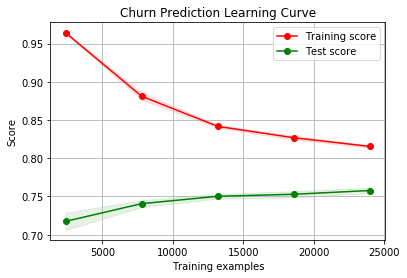

In [11]:
plot_learning_curve(make_pl(X, y), 'Churn Prediction Learning Curve', X, y).show()

_Можем использовать сокращенную выборку размером 15к._

2\. Часто несбалансированные по классам выборки приводят к различным проблемам при обучении моделей. Давайте попробуем по-разному обработать выборку, поиграть с распределением объектов по классам и сделать выводы о том, как соотношение классов влияет на качество модели.

2.1\. Задайте веса объектам так, чтобы соотношение классов с учетом весов объектов изменилось. Попробуйте не менее трёх различных вариантов весов. Меняются ли результаты классификации? Как это сказывается на качестве модели? Какой вариант выглядит наиболее оптимальным с точки зрения качества?

In [12]:
# меняем веса классов и проверям на CV
print "class_weight=1, small sample, roc_auc CV: {}".format(get_score(X_small, y_small))
print "class_weight=5, small sample, roc_auc CV: {}".format(get_score(X_small, y_small, class_weight=5))
print "class_weight=12, small sample, roc_auc CV: {}".format(get_score(X_small, y_small, class_weight=12))

# проверим, на hold out выборке
print "class_weight=1, hold out, roc_auc: {}".format(make_prediction(X, y, X_hold_out, y_hold_out, class_weight_train=1, class_weight_test=1))
print "class_weight=12, hold out, roc_auc: {}".format(make_prediction(X, y, X_hold_out, y_hold_out, class_weight_train=12, class_weight_test=12))

class_weight=1, small sample, roc_auc CV: 0.731635505504
class_weight=5, small sample, roc_auc CV: 0.727918802837
class_weight=12, small sample, roc_auc CV: 0.723844884511
class_weight=1, hold out, roc_auc: 0.7484912954
class_weight=12, hold out, roc_auc: 0.742011513432


_Выглядит так, что добавления весов объектам разных классов не оказывают положительного влияния на скор._

2.2\. Примените к выборке технологию undersampling: для этого нужно убрать из обучения некоторое количество объектов большего класса таким образом, чтобы соотношение классов изменилось. Попробуйте не менее трёх различных вариантов undersampling (варианты могут отличаться как по количество отфильтрованных объектов, так и по принципу выборка объектов для отсеивания из выборки). Меняются ли результаты классификации? Как это сказывается на качестве модели? Какой вариант выглядит наиболее оптимальным с точки зрения качества?

In [13]:
transformer = make_pl(X, y).steps[:-1][0][1]
X_transformed = transformer.fit_transform(X)  # трансформированные данные 

In [14]:
# random undersampling
Xy_calss0_under = Xy_calss0.sample(len(Xy_calss1))
Xy_random_undersampling = pd.concat([Xy_calss0_under, Xy_calss1], axis=0)

X_random_undersampling = Xy_random_undersampling.drop(['target'], axis=1)
y_random_undersampling = Xy_random_undersampling.target

print "random undersampling, full sample, roc_auc CV: {}".format(get_score(X_random_undersampling, y_random_undersampling))
print "random undersampling, hold out, roc_auc: {}".format(make_prediction(X_random_undersampling, y_random_undersampling, X_hold_out, y_hold_out))

random undersampling, full sample, roc_auc CV: 0.724910298812
random undersampling, hold out, roc_auc: 0.736070989071


In [15]:
# random oversampling
Xy_calss1_over = Xy_calss1.sample(len(Xy_calss0), replace=True)
Xy_random_oversampling = pd.concat([Xy_calss0, Xy_calss1_over], axis=0)

X_random_oversampling = Xy_random_oversampling.drop(['target'], axis=1)
y_random_oversampling = Xy_random_oversampling.target

print "random oversampling, full sample, roc_auc CV: {}".format(get_score(X_random_oversampling, y_random_oversampling))
print "random oversampling, hold out, roc_auc: {}".format(make_prediction(X_random_oversampling, y_random_oversampling, X_hold_out, y_hold_out))

random oversampling, full sample, roc_auc CV: 0.812229171234
random oversampling, hold out, roc_auc: 0.734450609044


In [16]:
# Under-sampling: Tomek links
tl = TomekLinks(random_state=42)
X_tl, y_tl = tl.fit_sample(X_transformed, y)

print "Tomek links, full sample, roc_auc CV: {}".format(get_score(X_tl, y_tl, without_pl=1))
print "Tomek links, hold out, roc_auc: {}".format(make_prediction(X_tl, y_tl, X_hold_out, y_hold_out, transformer))

Tomek links, full sample, roc_auc CV: 0.757723488049
Tomek links, hold out, roc_auc: 0.709541339897


In [88]:
# Under-sampling: Cluster Centroids 
cc = ClusterCentroids(random_state=42)
X_cc, y_cc = cc.fit_sample(X_transformed, y)

print "Cluster Centroids , full sample, roc_auc CV: {}".format(get_score(X_cc, y_cc, without_pl=1))
print "Cluster Centroids , hold out, roc_auc: {}".format(make_prediction(X_cc, y_cc, X_hold_out, y_hold_out, transformer))

Cluster Centroids , full sample, roc_auc CV: 0.991555744934
Cluster Centroids , hold out, roc_auc: 0.61356434938


In [87]:
# Over-sampling: SMOTE
smote = SMOTE(ratio='minority')
X_sm, y_sm = smote.fit_sample(X_transformed, y)

print "SMOTE, full sample, roc_auc CV: {}".format(get_score(X_sm, y_sm, without_pl=1))
print "SMOTE, hold out, roc_auc: {}".format(make_prediction(X_sm, y_sm, X_hold_out, y_hold_out, transformer))

SMOTE, full sample, roc_auc CV: 0.973802857111
SMOTE, hold out, roc_auc: 0.717037064075


_Применение undersampling/oversampling не оказывает положительного влияния на скор модели._

3\. Теперь перейдем к работе с признаками. Ранее вы реализовали несколько стратегий для обработки пропущенных значений. Сравните эти стратегии между собой с помощью оценки качества моделей кросс-валидации, построенных на датасетах с использованием различных стратегий. Как обработка пропущенных значений сказывается на качестве модели? Какой вариант выглядит наиболее оптимальным с точки зрения качества?

In [17]:
print "mean, small sample, roc_auc CV: {}".format(get_score(X_small, y_small, num_fill_zeros__strategy='mean'))
print "median, small sample, roc_auc CV: {}".format(get_score(X_small, y_small, num_fill_zeros__strategy='median'))
print "most_frequent, small sample, roc_auc CV: {}".format(get_score(X_small, y_small, num_fill_zeros__strategy='most_frequent'))

mean, small sample, roc_auc CV: 0.731635505504
median, small sample, roc_auc CV: 0.72335791986
most_frequent, small sample, roc_auc CV: 0.725678296123


_Наиболее эффективным является замена пропусков средним значением._

4\. Также вы уже реализовали несколько стратегий для обработки категориальных признаков. Сравните эти стратегии между собой с помощью оценки качества моделей по кросс-валидации, построенных на датасетах с использованием различных стратегий. Как обработка категориальных признаков сказывается на качестве модели? Какой вариант выглядит наиболее оптимальным с точки зрения качества?

In [18]:
print "no cat, small sample, roc_auc CV: {}".format(get_score(X_small, y_small, enabled_transformers = []))
print "ohe, small sample, roc_auc CV: {}".format(get_score(X_small, y_small, enabled_transformers = ['cats_ohe']))
print "ohe|ohe_trick, small sample, roc_auc CV: {}".format(get_score(X_small, y_small, enabled_transformers = ['cats_ohe', 'cats_ohe_trick']))
print "ohe|ohe_trick|positive_probability, small sample, roc_auc CV: {}".format(get_score(X_small, y_small, enabled_transformers = ['cats_ohe', 'cats_ohe_trick', 'cats_positive_probability']))
print "ohe|ohe_trick|positive_probability|hashing_trick, small sample, roc_auc CV: {}".format(get_score(X_small, y_small, enabled_transformers = ['cats_ohe', 'cats_ohe_trick', 'cats_positive_probability', 'cats_hashing_trick']))
print "positive_probability|hashing_trick, small sample, roc_auc CV: {}".format(get_score(X_small, y_small, enabled_transformers = ['cats_positive_probability', 'cats_hashing_trick']))
print "ohe|positive_probability, small sample, roc_auc CV: {}".format(get_score(X_small, y_small, enabled_transformers = ['cats_ohe', 'cats_positive_probability']))

no cat, small sample, roc_auc CV: 0.71319805046
ohe, small sample, roc_auc CV: 0.727334970504
ohe|ohe_trick, small sample, roc_auc CV: 0.727334970504
ohe|ohe_trick|positive_probability, small sample, roc_auc CV: 0.731635505504
ohe|ohe_trick|positive_probability|hashing_trick, small sample, roc_auc CV: 0.731635505504
positive_probability|hashing_trick, small sample, roc_auc CV: 0.7286151503
ohe|positive_probability, small sample, roc_auc CV: 0.731635505504


_Будем использовать: OneHotEncoding, замена значения вероятностью позитивного класса_

5\. Все ли признаки оказались полезными для построения моделей? Проведите процедуру отбора признаков, попробуйте разные варианты отбора (обратите внимание на модуль `sklearn.feature_selection`). Например, можно выбрасывать случайные признаки или строить отбор на основе l1-регуляризации - отфильтровать из обучения признаки, которые получат нулевой вес при построении регрессии с l1-регуляризацией (`sklearn.linear_model.Lasso`). И всегда можно придумать что-то своё=) Попробуйте как минимум 2 различные стратегии, сравните результаты. Помог ли отбор признаков улучшить качество модели? Поясните свой ответ.

In [19]:
def get_feature_importances(X, y):
    ''' возвращает признаки + значимость '''
    pl = make_pl(X, y, enabled_transformers = ['cats_ohe', 'cats_positive_probability'])
    X_transformed = pl.steps[:-1][0][1].fit_transform(X)  # трансформированные данные 
    model = get_classifier().fit(X_transformed, y)
    
    feature_importances = model.feature_importances_
    thresholds = sort(list(set(feature_importances)))
    return model, X_transformed, zip(features_names, feature_importances), thresholds

def get_score_with_diff_features(thresholds, model, X_transformed):
    ''' скор модели в зависимости от кол-ва признаков '''
    
    for thresh in thresholds:
        X_selected = SelectFromModel(model, threshold=thresh, prefit=True).transform(X_transformed)

        cv = StratifiedKFold(n_splits=3, random_state=1)
        score = cross_val_score(get_classifier(), X_selected, y_small, cv=cv, scoring='roc_auc')
        print "Thresh={}, n = {}, roc_auc = {}".format(thresh, X_selected.shape[1], score.mean())    
        
def get_unimportant_features(feature_importances, threshold):
    ''' формирует списки не важных признаков'''
    
    unimportant_features = [t[0] for t in feature_importances if t[1] < threshold]
    unimportant_features_numbers = list(set(unimportant_features).intersection(columns_numbers))
    unimportant_features_cat = list(set(unimportant_features).intersection(columns_cat))
    
    for col_name in columns_cat:
        l1 = len([t[0] for t in feature_importances if t[0].startswith(col_name + '=')])
        l2 = len(full_df[col_name].value_counts())
        if l1 == l2:
            unimportant_features_cat.append(col_name)

    return unimportant_features_numbers #+ unimportant_features_cat

In [20]:
# получаем список важности признаков от XGBoost
model, X_trans, feature_importances, thresholds = get_feature_importances(X_small, y_small)

In [21]:
# смотрим, как влияет кол-во признаков на скор 
get_score_with_diff_features(thresholds, model, X_trans)

Thresh=0.0, n = 357, roc_auc = 0.731352111008
Thresh=0.00154320988804, n = 91, roc_auc = 0.733691197531
Thresh=0.00308641977608, n = 62, roc_auc = 0.736527435857
Thresh=0.00462962966412, n = 56, roc_auc = 0.736491190876
Thresh=0.00617283955216, n = 45, roc_auc = 0.73418780159
Thresh=0.00771604944021, n = 39, roc_auc = 0.734664422738
Thresh=0.00925925932825, n = 33, roc_auc = 0.734799482045
Thresh=0.0108024692163, n = 28, roc_auc = 0.735629670148
Thresh=0.0123456791043, n = 25, roc_auc = 0.737809940128
Thresh=0.0138888889924, n = 22, roc_auc = 0.737484943199
Thresh=0.0154320988804, n = 18, roc_auc = 0.737479436485
Thresh=0.0185185186565, n = 17, roc_auc = 0.738213015725
Thresh=0.0200617276132, n = 16, roc_auc = 0.739998048251
Thresh=0.0231481473893, n = 15, roc_auc = 0.739576371218
Thresh=0.0246913582087, n = 12, roc_auc = 0.739265920648
Thresh=0.0262345671654, n = 9, roc_auc = 0.737142359283
Thresh=0.0293209869415, n = 8, roc_auc = 0.727991596323
Thresh=0.0324074067175, n = 7, roc_auc 

In [22]:
# формируем список не важных признаков 
unimportant_features = get_unimportant_features(feature_importances, 0.020)

In [23]:
# формируем выборку без "плохих" признаков
(X, y, X_small, y_small, X_hold_out, y_hold_out, 
    columns, columns_numbers, columns_cat,
    Xy, Xy_calss0, Xy_calss1) = sample_prepare(full_df, unimportant_features)

In [24]:
print "selected features, small sample, roc_auc CV: {}".format(get_score(X_small, y_small, enabled_transformers = ['cats_ohe', 'cats_positive_probability']))
print "selected features, full sample, roc_auc CV: {}".format(get_score(X, y, enabled_transformers = ['cats_ohe', 'cats_positive_probability']))

selected features, small sample, roc_auc CV: 0.7424946181
selected features, full sample, roc_auc CV: 0.758202907957


_Отбор признаков улучшил качество модели и ускорил обучение._

6\. Подберите оптимальные параметры модели. Обратите внимание, что в зависимости от того, как вы обработали исходные данные, сделали ли балансировку классов, сколько объектов оставили в обучающей выборке и др. оптимальные значения параметров могут меняться. Возьмите наилучшее из ваших решений на текущий момент и проведите процедуру подбора параметров модели (обратите внимание на `sklearn.model_selection.GridSearchCV`) Как подбор параметров повлиял на качество модели?

In [ ]:
pl = make_pl(X_small, y_small, enabled_transformers = ['cats_ohe', 'cats_positive_probability'])

params = {
        'classifier__min_child_weight': [1, 5, 10],
        'classifier__gamma': [7, 8, 9],
        'classifier__subsample': [0.5, 0.6, 0.8],
        'classifier__colsample_bytree': [0.5, 0.6, 0.8],
        'classifier__n_estimators': [30, 50, 100, 150],
        'classifier__max_depth': [1, 2, 3, 4]
        }

search_clf = GridSearchCV(pl, params, scoring='roc_auc')
search_clf.fit(X_small, y_small)
search_clf.best_score_, search_clf.best_params_

_Подбор гиперпараметров улучшил качество модели._

7\. Предложите методику оценки того, какие признаки внесли наибольший вклад в модель (например, это могут быть веса в случае регрессии, а также большое количество моделей реализуют метод `feature_importances_` - оценка важности признаков). На основе предложенной методики проанализируйте, какие признаки внесли больший вклад в модель, а какие меньший?

In [26]:
feature_importances_sorted = sorted(feature_importances, key=lambda tup: tup[1])

print 'Топ 10 важных признаков: ' + ', '.join([t[0] for t in feature_importances_sorted[-10:]])
print 
print 'Не важные признаки: ' + ', '.join([t[0] for t in feature_importances if t[1] == 0])

Топ 10 важных признаков: Var228, Var73, Var199, Var81, Var218=no_data, Var74, Var204, Var189, Var113, Var126

Не важные признаки: Var2, Var3, Var4, Var5, Var7, Var9, Var10, Var11, Var12, Var14, Var17, Var18, Var19, Var23, Var24, Var26, Var27, Var29, Var30, Var33, Var34, Var36, Var37, Var40, Var41, Var43, Var44, Var45, Var46, Var47, Var49, Var51, Var53, Var54, Var58, Var59, Var60, Var62, Var63, Var64, Var66, Var67, Var68, Var70, Var75, Var77, Var78, Var80, Var82, Var84, Var87, Var88, Var89, Var90, Var91, Var93, Var95, Var96, Var97, Var99, Var100, Var101, Var103, Var104, Var105, Var106, Var107, Var108, Var110, Var115, Var116, Var117, Var118, Var120, Var121, Var122, Var124, Var127, Var128, Var129, Var130, Var131, Var135, Var136, Var137, Var138, Var139, Var142, Var143, Var144, Var145, Var146, Var147, Var148, Var151, Var152, Var155, Var156, Var157, Var161, Var162, Var164, Var165, Var166, Var168, Var170, Var171, Var172, Var173, Var174, Var176, Var177, Var178, Var179, Var180, Var182, Var183, 

8\. Напоследок давайте посмотрим на объекты. На каких объектах достигается наибольшая ошибка классификации? Есть ли межу этими объектами что-то общее? Видны ли какие-либо закономерности? Предположите, почему наибольшая ошибка достигается именно на этих объектах. В данном случае "наибольшую" ошибку можно понимать как отнесение объекта с чужому классу с большой долей уверенности (с высокой вероятностью).

In [28]:
y_predict_proba = get_prediction_proba(X, y, X_hold_out, 
         enabled_transformers = ['cats_ohe', 'cats_positive_probability'], xgb_params=classifier_params)

In [65]:
print y_predict_proba[:, 1][y_hold_out.values == 1].mean()
print y_predict_proba[:, 1][y_hold_out.values == 0].mean()
top_features = ['Var228', 'Var73', 'Var199', 'Var81', 'Var218', 'Var74', 'Var204', 'Var189', 'Var113', 'Var126']

0.14400561
0.0678166


In [76]:
false_positive = X_hold_out[(y_hold_out.values == 1) & (y_predict_proba[:, 1] <= 0.04)][top_features]
true_positive = X_hold_out[(y_hold_out.values == 1) & (y_predict_proba[:, 1] > 0.2)][top_features]
print len(false_positive), len(true_positive)

40 72


In [77]:
false_positive.head(10)

,Var228,Var73,Var199,Var81,Var218,Var74,Var204,Var189,Var113,Var126
4859,TCU50_Yjmm6GIBZ0lL_,174,_jTP8ioIlJ,3815.76,cJvF,28.0,nr0d,NaN,10629.28,NaN
23096,F2FyR07IdsN7I,4,jnKgqlO5Ag,NaN,UYBR,NaN,rGJy,210.0,-2946316.00,-20.0
21124,F2FyR07IdsN7I,38,3X0xOLn,43934.40,cJvF,21.0,lXxA,NaN,-805452.00,-20.0
29842,F2FyR07IdsN7I,40,e1XhvTunuD,214423.20,cJvF,28.0,rzbc,NaN,161273.20,16.0
17496,SbOd7O8ky1wGNxp0Arj0Xs,58,Oe4E7cR6Kt,105731.70,cJvF,35.0,EKFb,216.0,102601.20,4.0
39041,NoEd,214,_jTP8ioIlJ,42865.20,cJvF,0.0,e7QV,NaN,220691.20,4.0
30630,F2FyR07IdsN7I,82,JsluJ5C,70329.30,cJvF,252.0,X8zP,NaN,-298746.40,-26.0
14655,ib5G6X1eUxUn6,158,9YuT4s0Bqf,12634.89,cJvF,231.0,LqKm,NaN,-50162.00,32.0
30283,F2FyR07IdsN7I,62,lGXpFd_2Rf,15880.86,UYBR,119.0,t_4G,NaN,-1930.00,38.0
2622,ib5G6X1eUxUn6,178,FoJylxy,15298.89,UYBR,287.0,TjV7,NaN,-254426.40,58.0


In [78]:
true_positive.head(10)

,Var228,Var73,Var199,Var81,Var218,Var74,Var204,Var189,Var113,Var126
3434,am14IcfM7tWLrUmRT52KtA,42,nQUHwv83X4,47823.9,NaN,49.0,vzJD,234.0,133014.0,NaN
26782,F2FyR07IdsN7I,16,ToUSgkq,90967.5,NaN,0.0,mTeA,NaN,-150214.0,4.0
7656,F2FyR07IdsN7I,56,3cOC7qZ,202095.0,UYBR,560.0,F_Lu,138.0,261366.0,NaN
14712,SbOd7O8ky1wGNxp0Arj0Xs,86,bAyfFVUl1u,39010.5,UYBR,56.0,rGJy,144.0,60132.0,-8.0
8054,F2FyR07IdsN7I,12,ZIX6Y9cVy5,226862.4,cJvF,0.0,MBhA,NaN,-452788.0,NaN
16900,F2FyR07IdsN7I,18,BpHkmkQ,126200.4,UYBR,0.0,k13i,120.0,186638.8,-6.0
34677,F2FyR07IdsN7I,16,0IWZqtp,220283.4,UYBR,0.0,xQ2A,NaN,95964.4,-8.0
38571,F2FyR07IdsN7I,16,fgUKl_eyza,253867.5,UYBR,0.0,mTeA,168.0,-299345.2,-10.0
30592,F2FyR07IdsN7I,16,AdrCSJ3,204726.9,UYBR,0.0,RVjC,NaN,928520.0,-8.0
13022,F2FyR07IdsN7I,16,hOpRIhsUSP,165378.3,UYBR,0.0,STGZ,150.0,52466.4,-10.0


In [79]:
false_positive.describe()

,Var73,Var81,Var74,Var189,Var113,Var126
count,40.000000,34.000000,32.000000,15.000000,4.000000e+01,34.000000
mean,87.350000,77273.189647,147.656250,264.800000,-2.243335e+05,1.705882
std,68.921937,78063.950136,253.858306,67.459194,8.263466e+05,27.022470
min,4.000000,0.000000,0.000000,180.000000,-2.946316e+06,-30.000000
25%,33.500000,13576.972500,12.250000,213.000000,-2.340252e+05,-20.000000
50%,63.000000,47048.700000,28.000000,246.000000,-1.586000e+04,4.000000
75%,134.500000,127106.700000,189.000000,318.000000,1.397089e+05,14.000000
max,244.000000,227069.100000,1204.000000,378.000000,1.709008e+06,64.000000


In [80]:
true_positive.describe()

,Var73,Var81,Var74,Var189,Var113,Var126
count,72.000000,66.000000,65.000000,34.000000,7.200000e+01,45.000000
mean,35.805556,138810.717121,21.969231,172.764706,1.680424e+04,-1.911111
std,28.252702,93460.942040,94.296237,48.469959,8.459308e+05,12.247119
min,6.000000,0.000000,0.000000,120.000000,-2.992656e+06,-18.000000
25%,16.000000,41213.850000,0.000000,139.500000,-1.713304e+05,-8.000000
50%,22.000000,167314.500000,0.000000,156.000000,6.922180e+04,-8.000000
75%,48.000000,202302.900000,0.000000,196.500000,3.718698e+05,4.000000
max,120.000000,340434.000000,560.000000,336.000000,1.895820e+06,38.000000


In [82]:
false_positive['Var228'].value_counts()

F2FyR07IdsN7I             21
TCU50_Yjmm6GIBZ0lL_        4
ib5G6X1eUxUn6              3
R4y5gQQWY8OodqDV           2
NoEd                       2
55YFVY9                    2
xwM2aC7IdeMC0              1
SbOd7O8ky1wGNxp0Arj0Xs     1
WfJ2BB2SFSqauljlfOB        1
VjDE                       1
iyHGyLCEkQ                 1
b9qbUNk0dML_Mvi2           1
Name: Var228, dtype: int64

In [83]:
true_positive['Var228'].value_counts()

F2FyR07IdsN7I             58
SbOd7O8ky1wGNxp0Arj0Xs     4
am14IcfM7tWLrUmRT52KtA     3
Zy3gnGM                    2
R4y5gQQWY8OodqDV           1
xwM2aC7IdeMC0              1
WfJ2BB2SFSqauljlfOB        1
55YFVY9                    1
F2FcTt7IdMT_v              1
Name: Var228, dtype: int64

_Объекты, на которых ошибается классификатор выглядят, как выбросы._

9\. По итогам проведенных экспериментов постройте финальную решение - модель с наилучшим качеством. Укажите, какие преобразования данных, параметры и пр. вы выбрали для построения финальной модели.

In [27]:
classifier_params = {'colsample_bytree': 0.5,
  'gamma': 8,
  'max_depth': 4,
  'min_child_weight': 1,
  'n_estimators': 150,
  'subsample': 0.8}

print "tuned xgb, small sample, roc_auc CV: {}".format(get_score(X_small, y_small, enabled_transformers = ['cats_ohe', 'cats_positive_probability'], xgb_params=classifier_params))
print "tuned xgb, full sample, roc_auc CV: {}".format(get_score(X, y, enabled_transformers = ['cats_ohe', 'cats_positive_probability'], xgb_params=classifier_params))
print "tuned xgb, hold out, roc_auc: {}".format(make_prediction(
    X, y, X_hold_out, y_hold_out,
    enabled_transformers = ['cats_ohe', 'cats_positive_probability'], xgb_params=classifier_params
))

tuned xgb, small sample, roc_auc CV: 0.744427343912
tuned xgb, full sample, roc_auc CV: 0.758385731169
tuned xgb, hold out, roc_auc: 0.746695797875


- замена пропущенных значений числовых признаков - средними значениями
- обработка категориальных признаков: OneHotEncoding, замена значения вероятностью  позитивного класса
- отбор признаков на основе модели и feature_importances XGBoost
- настройка гиперпараметров XGBoost

10\. Подумайте, можно ли еще улучшить модель? Что для этого можно сделать? 

_Можно еще поработать с категориальными признаками – пробовать другие варианты обработки._